<a href="https://colab.research.google.com/github/zeerafle/fraud-detection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection

## Setup

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data Preprocessing and Exploration

### Get the [Kaggle Credit Card Fraud](https://www.kaggle.com/datasets/kartik2112/fraud-detection?select=fraudTrain.csv) data set

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%%bash
pip install kaggle
mkdir ~/.kaggle
cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download -d kartik2112/fraud-detection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



100%|██████████| 202M/202M [00:06<00:00, 30.6MB/s]


In [5]:
%%bash
mkdir data
unzip fraud-detection.zip -d data

Archive:  fraud-detection.zip
  inflating: data/fraudTest.csv      
  inflating: data/fraudTrain.csv     


In [6]:
file = tf.keras.utils
raw_df = pd.read_csv('data/fraudTrain.csv')
raw_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [7]:
raw_df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [8]:
UNWANTED_COLS = ['cc_num', 'first', 'last',
                 'street', 'city', 'state',
                 'zip', 'trans_num', 'unix_time',
                 'merchant', 'job']

raw_df = raw_df.iloc[:, 1:]
raw_df.drop(columns=UNWANTED_COLS, inplace=True)
raw_df.shape

(1296675, 11)

### Examine the class label imbalance

In [9]:
neg, pos = np.bincount(raw_df['is_fraud'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1296675
    Positive: 7506 (0.58% of total)



### Feature Engineering

#### Getting person's age

In [10]:
trans_date = pd.to_datetime(raw_df.trans_date_trans_time, format="%Y-%m-%d %H:%M:%S")
dob = pd.to_datetime(raw_df.dob, format="%Y-%m-%d")

raw_df['age_when_trans'] = trans_date.map(lambda x: x.year) - dob.map(lambda x: x.year)
raw_df.age_when_trans

0          31
1          41
2          57
3          52
4          33
           ..
1296670    59
1296671    41
1296672    53
1296673    40
1296674    25
Name: age_when_trans, Length: 1296675, dtype: int64

(array([ 81311., 174087., 244642., 226105., 204589., 145037.,  98846.,
         54931.,  36709.,  30418.]),
 array([14. , 22.2, 30.4, 38.6, 46.8, 55. , 63.2, 71.4, 79.6, 87.8, 96. ]),
 <a list of 10 Patch objects>)

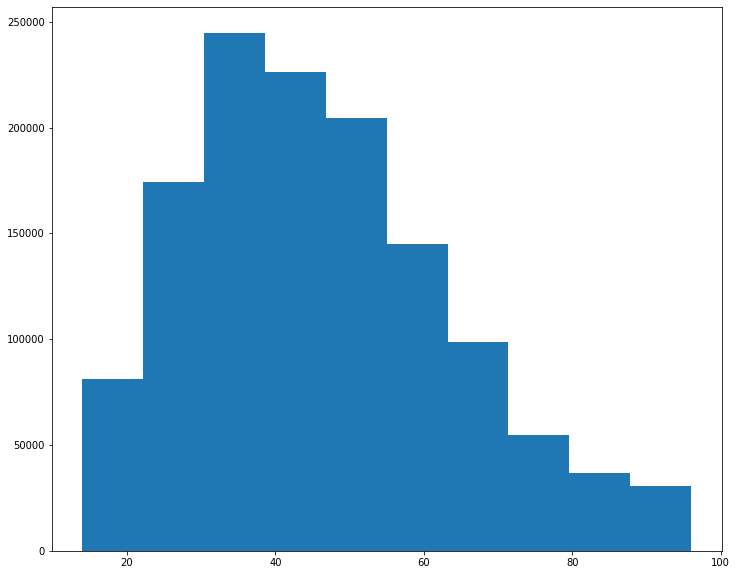

In [11]:
plt.hist(raw_df.age_when_trans)

#### Get time hour discrete value

In [12]:
raw_df['time_hour'] = trans_date.map(lambda x: x.hour)
raw_df.time_hour

0           0
1           0
2           0
3           0
4           0
           ..
1296670    12
1296671    12
1296672    12
1296673    12
1296674    12
Name: time_hour, Length: 1296675, dtype: int64

(array([128027.,  84632.,  84471., 126893.,  84353., 130571., 196002.,
        131501., 130606., 199619.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

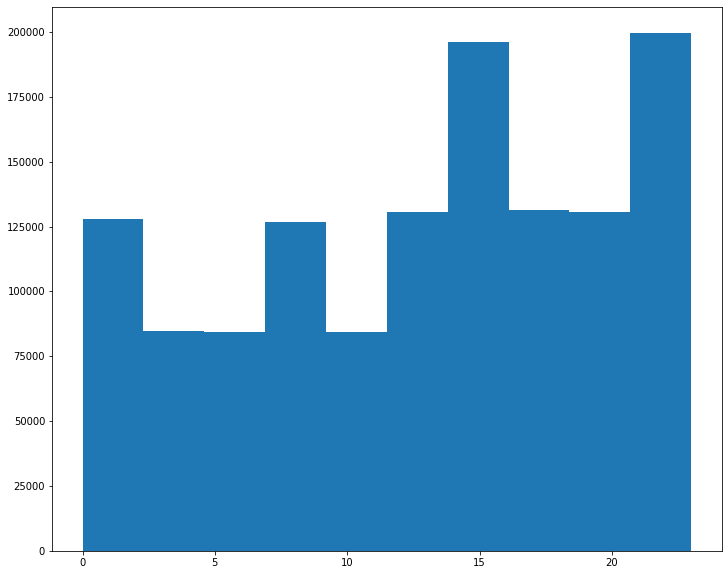

In [13]:
plt.hist(raw_df.time_hour)

#### Get day of week discrete value

In [21]:
print(trans_date[13820])
print(trans_date[0].weekday())

2019-01-08 19:04:00
1


In [24]:
raw_df['weekday'] = trans_date.map(lambda x: x.weekday())
raw_df.weekday

0          1
1          1
2          1
3          1
4          1
          ..
1296670    6
1296671    6
1296672    6
1296673    6
1296674    6
Name: weekday, Length: 1296675, dtype: int64

#### Get distance between credit card owner and merchant

Distance is calculated with euclidean distance on each latitude and longitude value

In [14]:
def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return np.sqrt(londiff*londiff + latdiff*latdiff)

In [15]:
raw_df['distance'] = raw_df[['lat', 'long', 'merch_lat', 'merch_long']].apply(euclidean, axis=1)
raw_df.distance

0          0.872830
1          0.272310
2          0.975845
3          0.919802
4          0.868505
             ...   
1296670    1.177732
1296671    0.819632
1296672    0.967541
1296673    0.898775
1296674    0.786883
Name: distance, Length: 1296675, dtype: float64

#### Apply the same preprocessing to test data

In [27]:
def feat_eng(df):
    UNWANTED_COLS = ['cc_num', 'first', 'last',
                    'street', 'city', 'state',
                    'zip', 'trans_num', 'unix_time',
                    'merchant', 'job']

    raw_df = df.iloc[:, 1:]
    raw_df.drop(columns=UNWANTED_COLS, inplace=True)
    
    trans_date = pd.to_datetime(raw_df.trans_date_trans_time, format="%Y-%m-%d %H:%M:%S")
    dob = pd.to_datetime(raw_df.dob, format="%Y-%m-%d")

    raw_df['age_when_trans'] = trans_date.map(lambda x: x.year) - dob.map(lambda x: x.year)
    raw_df['time_hour'] = trans_date.map(lambda x: x.hour)
    raw_df['weekday'] = trans_date.map(lambda x: x.weekday())
    raw_df['distance'] = raw_df[['lat', 'long', 'merch_lat', 'merch_long']].apply(euclidean, axis=1)

    return raw_df.drop(columns=['trans_date_trans_time', 'dob'])

#### Split Data

In [29]:
LABEL_COLUMN = 'is_fraud'

In [40]:
train_df = raw_df.drop(columns=['trans_date_trans_time', 'dob'])
train_df.head()

,category,amt,gender,lat,long,city_pop,merch_lat,merch_long,is_fraud,age_when_trans,time_hour,distance,weekday
0,misc_net,4.97,F,36.0788,-81.1781,3495,36.011293,-82.048315,0,31,0,0.872830,1
1,grocery_pos,107.23,F,48.8878,-118.2105,149,49.159047,-118.186462,0,41,0,0.272310,1
2,entertainment,220.11,M,42.1808,-112.2620,4154,43.150704,-112.154481,0,57,0,0.975845,1
3,gas_transport,45.00,M,46.2306,-112.1138,1939,47.034331,-112.561071,0,52,0,0.919802,1
4,misc_pos,41.96,M,38.4207,-79.4629,99,38.674999,-78.632459,0,33,0,0.868505,1


In [41]:
test_df = pd.read_csv('data/fraudTest.csv')
print(f'before feature engineering: {test_df.shape}')

test_df = feat_eng(test_df)
print(f'after feature engineering: {test_df.shape}')

before feature engineering: (555719, 23)
after feature engineering: (555719, 13)


In [42]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, val_df = train_test_split(train_df, test_size=0.2)

## Define the model and metrics

### Create Tensorflow dataset

In [50]:
CATEGORICAL_COLS = ['category', 'gender']
DISCRETE_COLS = ['time_hour', 'weekday']
NUMERIC_COLS = ['amt', 'city_pop', 'lat',
                'long', 'merch_lat', 'merch_long',
                'age_when_trans', 'distance']

In [37]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop(LABEL_COLUMN)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [43]:
BATCH_SIZE = 2048
train_ds = df_to_dataset(train_df, batch_size=BATCH_SIZE)
val_ds = df_to_dataset(val_df, shuffle=False, batch_size=BATCH_SIZE)

In [55]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of households:', feature_batch['city_pop'])
    print('A batch of ocean_proximity:', feature_batch['gender'])
    print('A batch of trans datetime:', feature_batch['age_when_trans'])
    print('A batch of targets:', label_batch)

Every feature: ['category', 'amt', 'gender', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age_when_trans', 'time_hour', 'distance', 'weekday']
A batch of households: tf.Tensor(
[641349   1789    800    118   1089 163415    595   1925   1690    313
    118    223  31394   5354    597 276002 841711   3688  55581   1423
   4677    471 673342   1946    168   2368 687276    207     77    836
    328   1807], shape=(32,), dtype=int64)
A batch of ocean_proximity: tf.Tensor(
[b'F' b'F' b'M' b'F' b'F' b'F' b'M' b'F' b'M' b'F' b'F' b'M' b'F' b'M'
 b'F' b'F' b'M' b'M' b'M' b'F' b'M' b'M' b'M' b'M' b'M' b'F' b'M' b'F'
 b'F' b'F' b'F' b'F'], shape=(32,), dtype=string)
A batch of trans datetime: tf.Tensor(
[43 37 87 62 48 15 40 54 45 43 62 80 23 54 58 86 57 46 47 21 64 79 52 30
 41 30 46 57 31 38 36 44], shape=(32,), dtype=int64)
A batch of targets: tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int64)


### Create input pipeline

In [44]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [45]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [51]:
all_inputs = dict()
encoded_features = []

In [52]:
# Numerical features.
for header in NUMERIC_COLS:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs[header] = numeric_col
    encoded_features.append(encoded_numeric_col)

In [53]:
for header in CATEGORICAL_COLS:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header,
                                                dataset=train_ds,
                                                dtype='string',
                                                max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs[header] = categorical_col
    encoded_features.append(encoded_categorical_col)

In [65]:
for header in DISCRETE_COLS:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
    encoding_layer = get_category_encoding_layer(name=header,
                                                dataset=train_ds,
                                                dtype='int64')
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs[header] = categorical_col
    encoded_features.append(encoded_categorical_col)

In [66]:
all_inputs

{'amt': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'amt')>,
 'city_pop': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'city_pop')>,
 'lat': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lat')>,
 'long': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'long')>,
 'merch_lat': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'merch_lat')>,
 'merch_long': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'merch_long')>,
 'age_when_trans': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age_when_trans')>,
 'distance': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'distance')>,
 'category': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'category')>,
 'gender': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'gender')>,
 'time_hour': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'time_hour')>,
 'weekday': <KerasTensor: shape=(None

In [67]:
encoded_features

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_3')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_4')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_5')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_6')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_7')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_8')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_1')>,
 <KerasTensor: shape=(None, 25) dtype=float32 (created by layer 'category_encoding_4')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'c

In [69]:
all_inputs_list = list(all_inputs.values())
all_inputs_list

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'amt')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'city_pop')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lat')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'long')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'merch_lat')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'merch_long')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age_when_trans')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'distance')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'category')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'gender')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'time_hour')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'weekday')>]

### Build the model

In [68]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [73]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(32, activation="relu")(all_features)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid',
                                   bias_initializer=output_bias)(x)

    model = tf.keras.Model(all_inputs, output)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS)

    return model


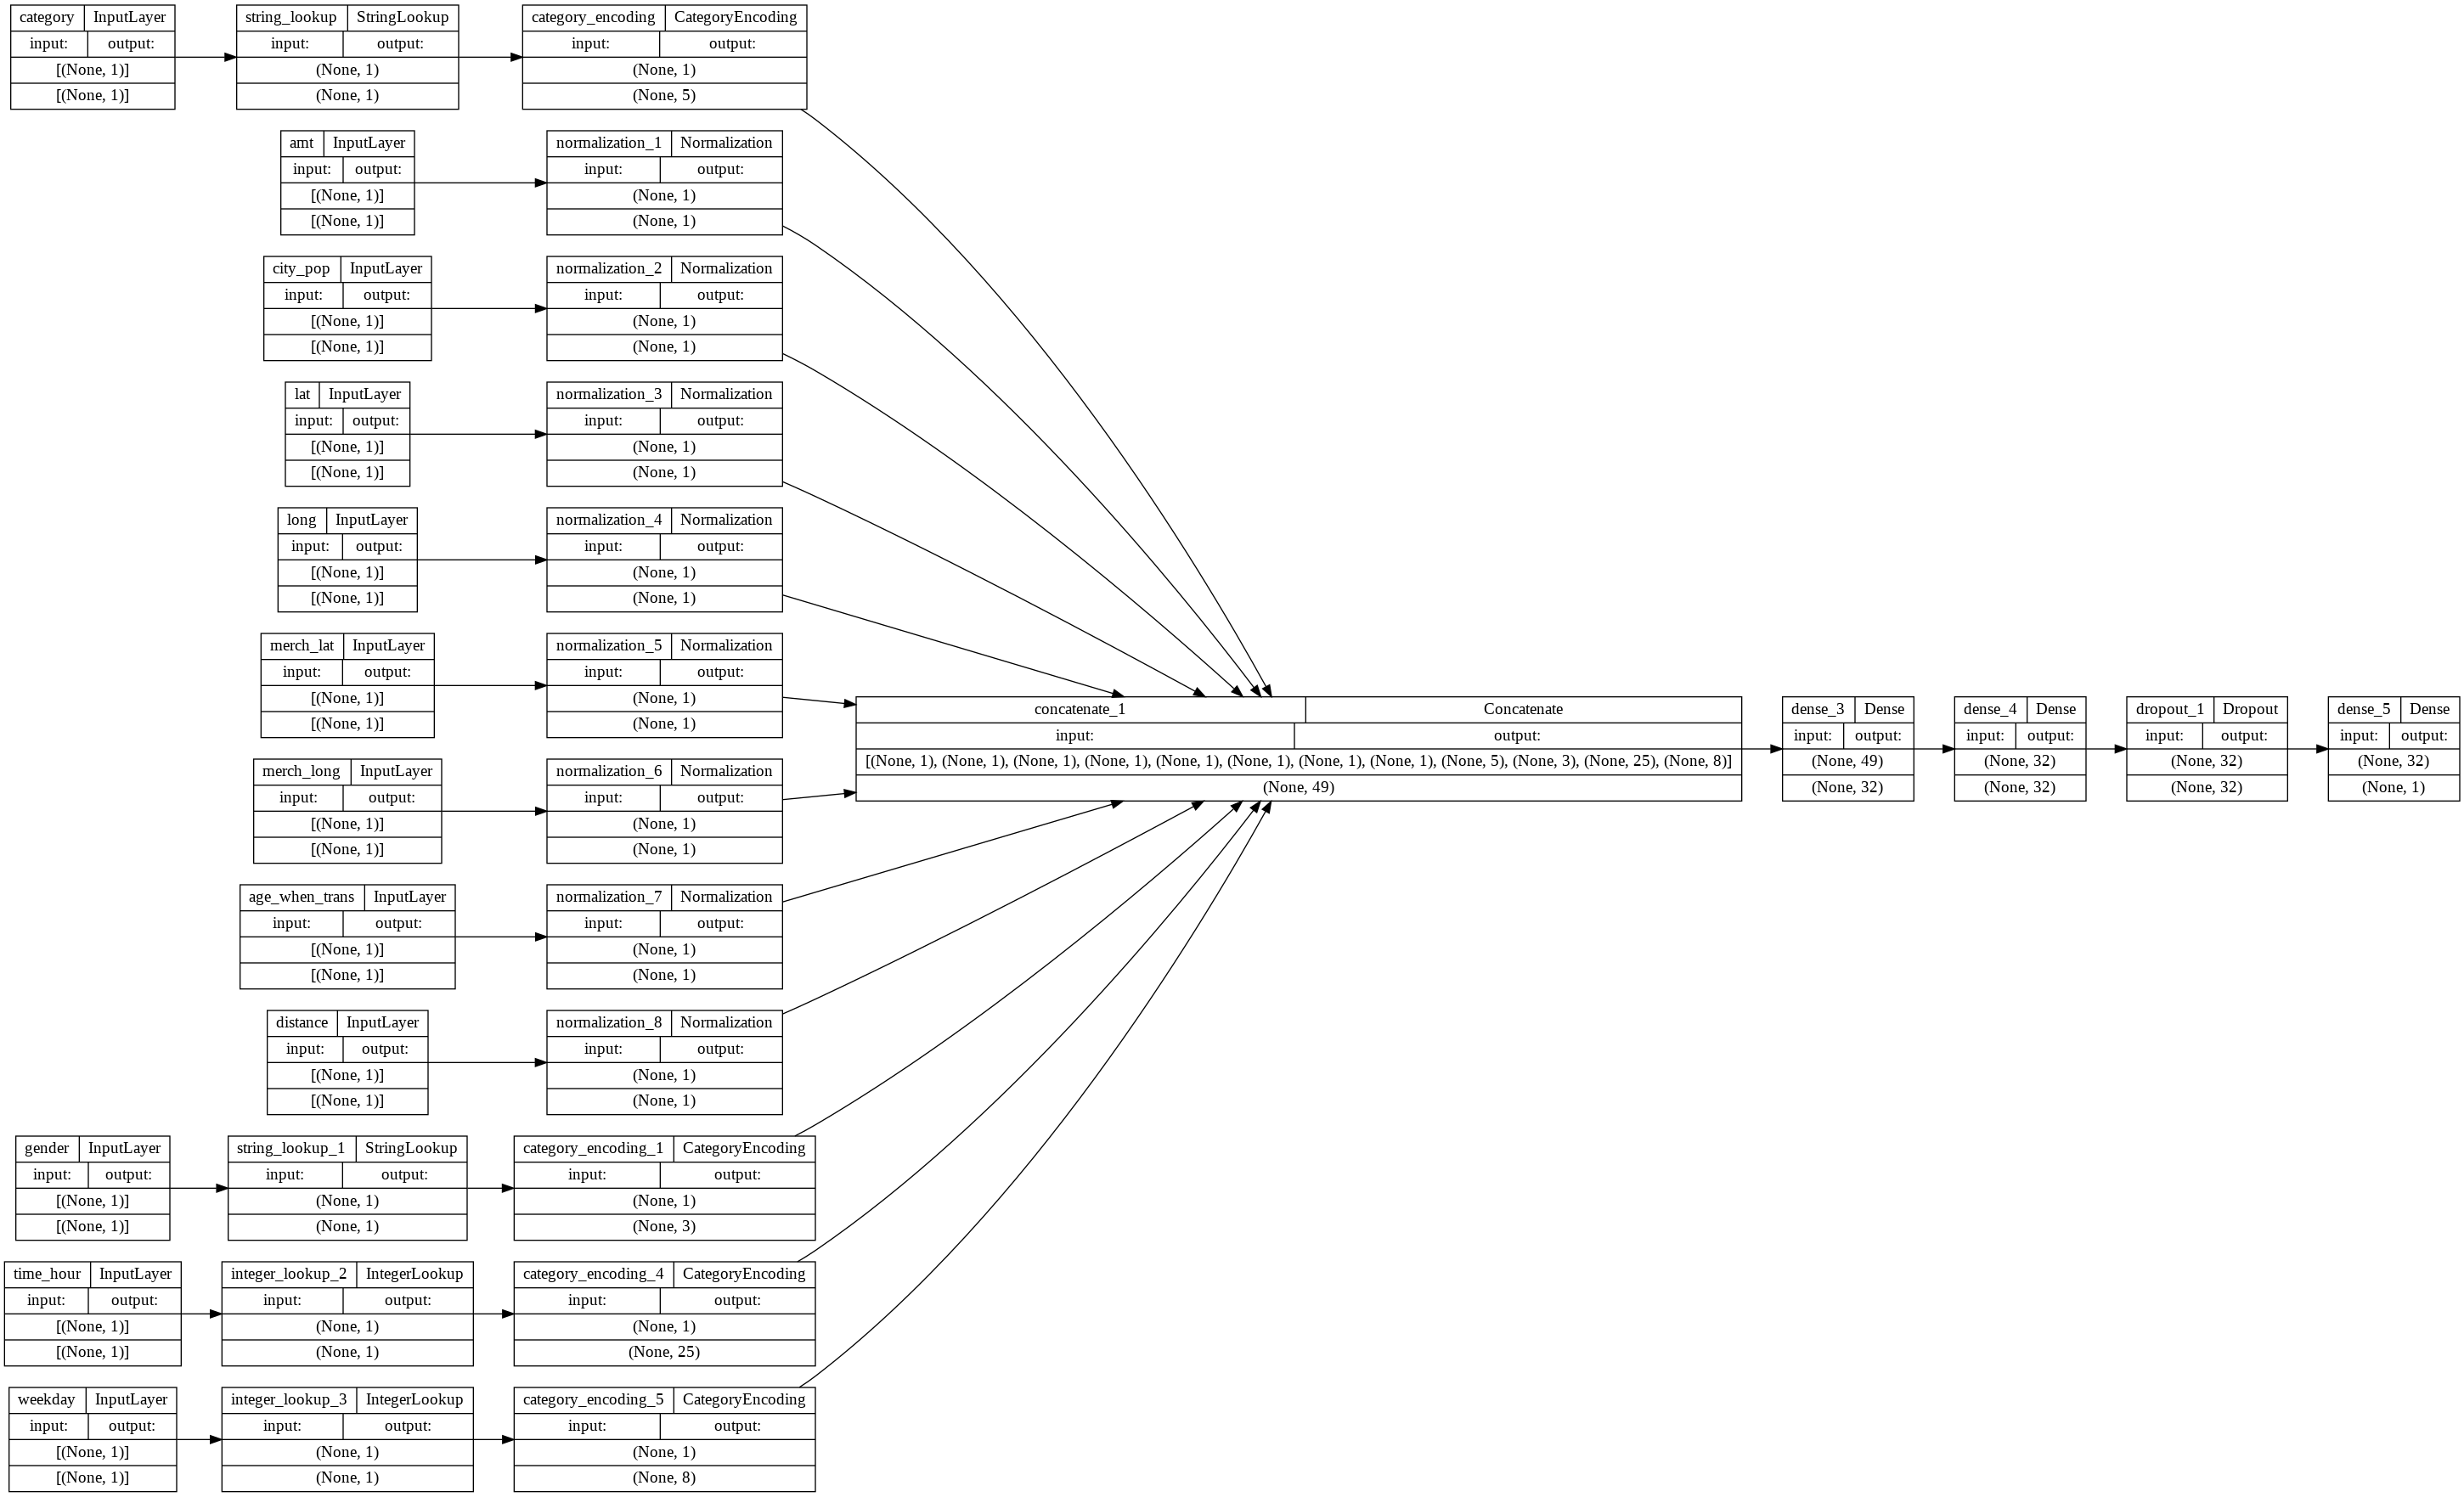

In [74]:
model = make_model()
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [75]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 category (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 gender (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 time_hour (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 weekday (InputLayer)           [(None, 1)]          0           []                               
                                                                                            

In [76]:
initial_bias = np.log([pos/neg])
initial_bias

array([-5.1460504])

### Class weights

In [77]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [78]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 86.38


#### Train with class weights

In [79]:
model.load_weights(initial_weights)
weighted_history = model.fit(
    train_ds,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=val_ds,
    # class weights
    class_weight=class_weight)

Epoch 1/10
32417/32417 [==============================] - 177s 5ms/step - loss: 0.2936 - tp: 5339.0000 - fp: 141448.0000 - tn: 889888.0000 - fn: 665.0000 - accuracy: 0.8630 - precision: 0.0364 - recall: 0.8892 - auc: 0.9474 - prc: 0.3472 - val_loss: 0.1506 - val_tp: 1319.0000 - val_fp: 20205.0000 - val_tn: 237628.0000 - val_fn: 183.0000 - val_accuracy: 0.9214 - val_precision: 0.0613 - val_recall: 0.8782 - val_auc: 0.9645 - val_prc: 0.5129
Epoch 2/10
32417/32417 [==============================] - 160s 5ms/step - loss: 0.2427 - tp: 5490.0000 - fp: 111644.0000 - tn: 919692.0000 - fn: 514.0000 - accuracy: 0.8919 - precision: 0.0469 - recall: 0.9144 - auc: 0.9627 - prc: 0.5154 - val_loss: 0.2419 - val_tp: 1417.0000 - val_fp: 32763.0000 - val_tn: 225070.0000 - val_fn: 85.0000 - val_accuracy: 0.8733 - val_precision: 0.0415 - val_recall: 0.9434 - val_auc: 0.9709 - val_prc: 0.5711
Epoch 3/10
32417/32417 [==============================] - 155s 5ms/step - loss: 0.2355 - tp: 5494.0000 - fp: 102663

## Evaluate Model

### Check Training History

In [80]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

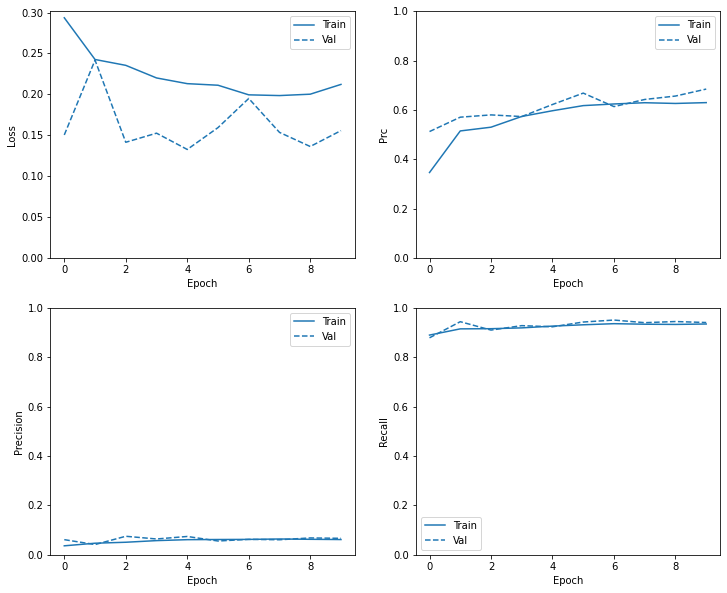

In [81]:
plot_metrics(weighted_history)

### Evaluate Metrics

In [82]:
test_ds = df_to_dataset(test_df, shuffle=False)

In [89]:
train_predictions = model.predict(train_ds)
test_predictions = model.predict(test_ds)

In [90]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [91]:
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

loss :  0.15696701407432556
tp :  1998.0
fp :  42768.0
tn :  510806.0
fn :  147.0
accuracy :  0.9227757453918457
precision :  0.044632088392972946
recall :  0.9314685463905334
auc :  0.9734569191932678
prc :  0.6078562140464783

Legitimate Transactions Detected (True Negatives):  510806
Legitimate Transactions Incorrectly Detected (False Positives):  42768
Fraudulent Transactions Missed (False Negatives):  147
Fraudulent Transactions Detected (True Positives):  1998
Total Fraudulent Transactions:  2145


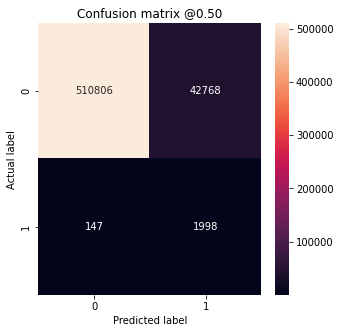

In [94]:
results = model.evaluate(test_ds, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions)

#### Plot ROC

In [95]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [96]:
train_labels = np.concatenate([y for x, y in train_ds], axis=0)

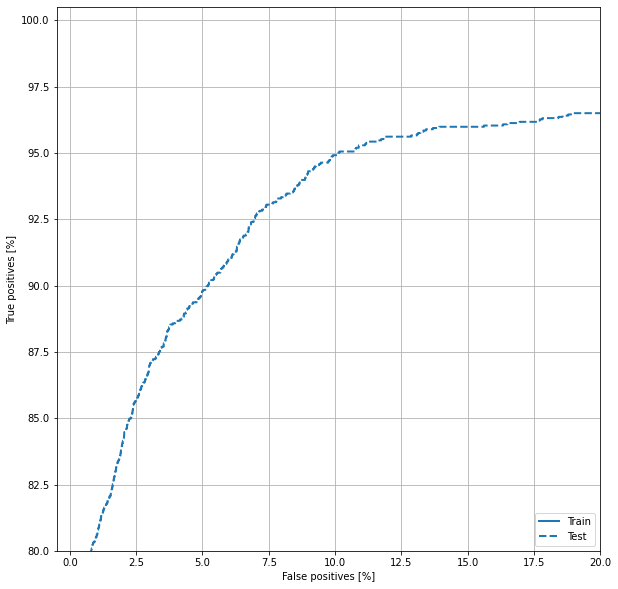

In [98]:
plot_roc("Train", train_labels, train_predictions, color=colors[0])
plot_roc("Test", test_labels, test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

#### Plot the AUPRC

In [99]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

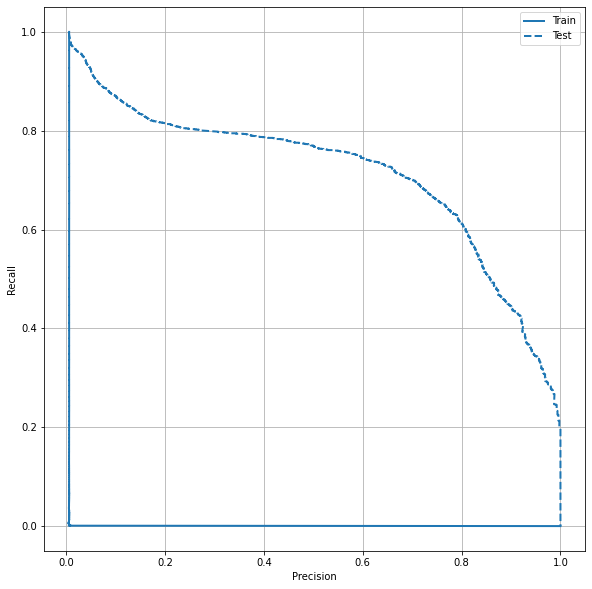

In [101]:
plot_prc("Train", train_labels, train_predictions, color=colors[0])
plot_prc("Test", test_labels, test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='upper right');